<a href="https://colab.research.google.com/github/yuu067/MIA-IABD-2425/blob/main/UD04/notebooks/EX4.-generant_dades_entrenament_camera_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EX4: Generación de datos de entrenamiento

## Introducción

En este cuaderno generaremos datos para entrenar una red neuronal para controlar el robot para seguir el circuito. Usaremos los datos que generamos en este cuaderno para entrenar una red neuronal en el siguiente cuaderno.

In [1]:
%pip install aitk.robots aitk.networks tensorflow numpy opencv-python-headless matplotlib requests Pillow==9.4 scikit-fuzzy==0.4.2 #aitk

## Preparamos el entorno

In [2]:
import aitk.robots as bots
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests

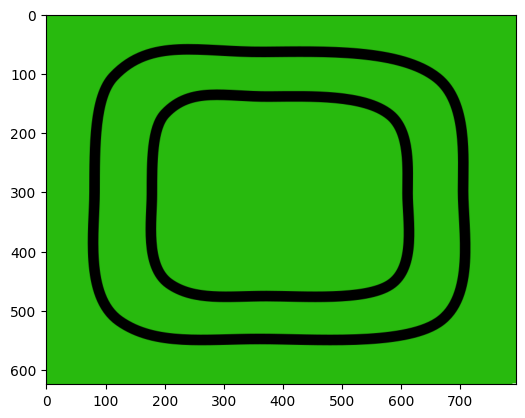

In [3]:
nom_imatge = "EX2_pista_6.png"

# Carreguem la imatge en una variable

img = cv2.imread(nom_imatge)

# Mostrem la imatge
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [15]:
world = bots.World(220, 180, boundary_wall_color="yellow", ground_image_filename=nom_imatge)

robot = bots.Scribbler(x=36, y=90, a=90)
robot.add_device(bots.GroundCamera(width=120, height=50))

world.add_robot(robot)

robot['ground-camera'].watch()
world.watch()

Random seed set to: 3093294


HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00x\x00\x00\x002\x08\x06\x00\x00\x00\x97\xa7\x1f\xd…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

## Generación de valores de movimiento y rotación

En la práctica anterior controlamos directamente el robot usando `robot.move(translate, rotate)`. Ahora queremos mover el robot y guardar los movimientos en un archivo. Para hacer esto, crearemos una función llamada `determine_move` que tomará los valores actuales de los sensores y devuelva una tupla que represente las cantidades de traslación y rotación apropiadas para esta situación, junto el valor central de la carretera.
Esta función será llamada por la función `move` que controla el robot.

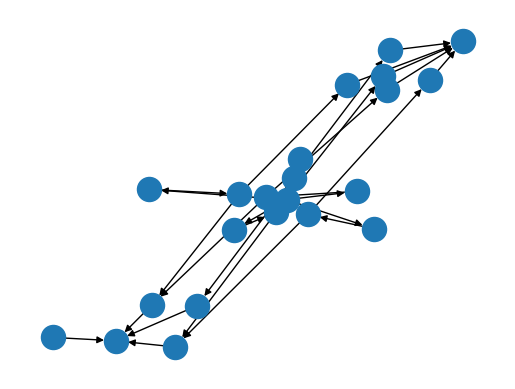

In [7]:
from skfuzzy import control as ctrl
import skfuzzy as fuzz
import numpy as np

rango_cam = np.arange(-120//2, 120//2, 1)

cam = ctrl.Antecedent(rango_cam, 'cam')

cam['m_negativo'] = fuzz.trimf(cam.universe,[-60,-60,-30])
cam['negativo'] = fuzz.trimf(cam.universe,[-60,-30,0])
cam['z'] = fuzz.trimf(cam.universe,[-30,0,30])
cam['positivo'] = fuzz.trimf(cam.universe,[0,30,60])
cam['m_positivo'] = fuzz.trimf(cam.universe,[30,60,60])
############################################################
rango_vel = np.arange(-1, 1, 0.05)

vel = ctrl.Consequent(rango_vel, 'vel')

vel['m_baja'] = fuzz.trimf(vel.universe,[0,0,0.25])
vel['baja'] = fuzz.trimf(vel.universe,[0,0.25,0.5])
vel['media'] = fuzz.trimf(vel.universe,[0.25,0.5,0.75])
vel['alta'] = fuzz.trimf(vel.universe,[0.75,1,1])
################################################################
rango_rot = np.arange(-1, 1, 0.05)

rot = ctrl.Consequent(rango_rot, 'rot')

rot['izq_tot'] = fuzz.trimf(rot.universe,[-1,-1,-0.5])
rot['izq'] = fuzz.trimf(rot.universe,[-1,-0.5,0])
rot['cent'] = fuzz.trimf(rot.universe,[-0.25,0,0.25])
rot['dch'] = fuzz.trimf(rot.universe,[0,0.5,1])
rot['dch_tot'] = fuzz.trimf(rot.universe,[0.5,1,1])
##############################################################

# Definimos las reglas
rule1 = ctrl.Rule(cam['z'], (rot['cent'], vel['alta']))
rule2 = ctrl.Rule(cam['positivo'], (rot['dch'], vel['media']))
rule3 = ctrl.Rule(cam['negativo'], (rot['izq'], vel['media']))
rule4 = ctrl.Rule(cam['m_negativo'], (rot['izq_tot'], vel['m_baja']))
rule5 = ctrl.Rule(cam['m_positivo'], (rot['dch_tot'], vel['m_baja']))

# Definimos el sistema de control
control = ctrl.ControlSystem([rule1,rule2,rule3,rule4,rule5])
# Simulamos el sistema de control
control.view()

controlador = ctrl.ControlSystemSimulation(control)

In [21]:
def controlador_difuso(cam):
    controlador.input['cam'] = cam
    controlador.compute()
    return (np.round(controlador.output['vel'],2),np.round(controlador.output['rot'],2))

def process_image(im):
    im_baix = im[0:25,0:120]
    plt.imshow(cv2.cvtColor(im_baix, cv2.COLOR_BGR2RGB))
    im_bn = cv2.cvtColor(im_baix, cv2.COLOR_BGR2GRAY)
    im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)
    ret, im_th = cv2.threshold(im_blurred,100,255,cv2.THRESH_BINARY)
    im_th_copy = im_th.copy()
    contours, _ = cv2.findContours(im_th_copy, 1, cv2.CHAIN_APPROX_NONE)
    dir = 0
    vel = 0.4
    if len(contours) > 0:
        max_contour = max(contours, key = cv2.contourArea)
        center = cv2.moments(max_contour)
        cx = int(center['m10']/center['m00'])
        cy = int(center['m01']/center['m00'])
        dir = 0
        offset = 5
        dif = im_th.shape[1]/2 - cx
        vel, dir = controlador_difuso(dif)
    return vel, dir, cx

def determine_move(robot):
    """
    Determina el movimiento del robot según las lecturas de sus sensores.
    Devuelva una tupla con la velocidad de traslación, la velocidad de rotación y el valor central de la carretera.
    El robot debe permanecer dentro de la pista durante el tiempo que dure la simulación.
    """
    cam = robot['ground-camera']
    cam.get_image().save("cam.png")
    im = cv2.imread("cam.png")
    moviment, rotacio, centre=process_image(im)

    return moviment, rotacio, centre

#### Probando la función `determine_move`

Necesitamos probar la función `determine_move` Y verifique que todavía controla correctamente el robot para seguir la pared. Para hacer esto, llamaremos a la función `determine_move` en un bucle y llamaremos `robot.move` con los valores de movimiento devueltos por la función `determine_move`. Esto debería hacer que el robot pase por el circuito sin ningún problema.

In [22]:
def controlador_cam(robot):
    translate, rotate, centre = determine_move(robot)
    robot.move(translate, rotate)

  0%|          | 0/300 [00:00<?, ?it/s]

Simulation stopped at: 00:00:30.00; speed 0.94 x real time


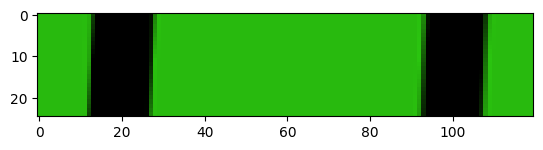

In [27]:
world.reset()

world.seconds(30, [controlador_cam], real_time=True)

### Generación de datos de entrenamiento

Ahora tenemos todas las piezas en el sitio para generar los datos de entrenamiento.

Queremos generar un conjunto de entrenamiento para nuestra red neuronal y el simulador de tiempo real será demasiado lento. Por lo tanto, utilizaremos la versión NO a tiempo real del simulador. Por eso usarém `realtime = False` cuando llamemos a `world.seconds`.

También debemos tener en cuenta, que para entrenar una red neuronal, todos los valores de los datos deben estar estandarizados para ajustarse al intervalo de la función de activación que utilizaremos. Usaremos una función de activación con un intervalo de [-1,1], ya que las órdenes del motor pueden ser negativas o positivas. Los valores del centro de la carretera estarán en el intervalo [0,100] por lo que la estandarización será simple: dividiremos por 100.

En cada línea del archivo que crearemos habrá valores de los sensores, separados por espacios en blanco, seguidos de órdenes de motor separados por espacios en blanco, que terminan con un salto de línea.

Un problema que tenemos que abordar es que nuestro programa de viajar por el circuito se puede detener en ciertas situaciones o volver hacia atrás. Debemos construir nuestra función de generación de datos con esto en mente. Por ejemplo, si se detiene el robot, no queremos que los datos de entrenamiento reflejen esta situación.

Crearemos la función `generate_data` para generar una lista de datos de entrenamiento.Esta característica debe generar un número fijo de datos de entrenamiento. Para cada iteración de entrenamiento, la función debe llamar`inici_aleatori` Para establecer la posición del robot en una ubicación aleatoria, reinicie el mundo y ejecute una simulación.

In [23]:
# Redefinimos la función controlador_cam para que añada los valores devueltos a "data"
data = []
def controlador_cam(robot):
    global data
    translate, rotate, centre = determine_move(robot)
    robot.move(translate, rotate)
    data.append([centre, translate, rotate])

def inici_aleatori(robot, world):
    robot.x = np.random.randint(36, 184)
    robot.y = np.random.randint(36, 144)
    robot.a = 90
    world.reset()
    world.seconds(30, [controlador_cam], real_time=False)

# Generamos los datos de manera masiva
def generate_data(robot, world, trials):
    for i in range(trials):
        inici_aleatori(robot, world)


  0%|          | 0/300 [00:00<?, ?it/s]

Simulation stopped at: 00:00:30.00; speed 27.78 x real time


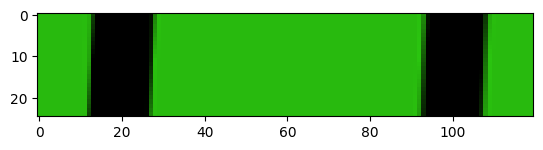

In [25]:
generate_data(robot, world, 20)

In [26]:
data

[[59, np.float64(0.82), np.float64(0.05)],
 [59, np.float64(0.82), np.float64(0.05)],
 [59, np.float64(0.82), np.float64(0.05)],
 [60, np.float64(0.88), np.float64(0.0)],
 [60, np.float64(0.88), np.float64(0.0)],
 [60, np.float64(0.88), np.float64(0.0)],
 [60, np.float64(0.88), np.float64(0.0)],
 [60, np.float64(0.88), np.float64(0.0)],
 [61, np.float64(0.82), np.float64(-0.06)],
 [61, np.float64(0.82), np.float64(-0.06)],
 [61, np.float64(0.82), np.float64(-0.06)],
 [60, np.float64(0.88), np.float64(0.0)],
 [60, np.float64(0.88), np.float64(0.0)],
 [60, np.float64(0.88), np.float64(0.0)],
 [60, np.float64(0.88), np.float64(0.0)],
 [60, np.float64(0.88), np.float64(0.0)],
 [61, np.float64(0.82), np.float64(-0.06)],
 [60, np.float64(0.88), np.float64(0.0)],
 [60, np.float64(0.88), np.float64(0.0)],
 [61, np.float64(0.82), np.float64(-0.06)],
 [61, np.float64(0.82), np.float64(-0.06)],
 [61, np.float64(0.82), np.float64(-0.06)],
 [61, np.float64(0.82), np.float64(-0.06)],
 [61, np.float6

Procesaremos los datos de entrenamiento en la siguiente celda. Aplicaremos las siguientes transformaciones:
- Normalizaremos los datos del sensor y las órdenes del motor para ajustar al intervalo de la función de activación. En nuestro caso, utilizaremos la función de activación `tanh`, que tiene un intervalo de [-1,1] y solo necesitamos normalizar los datos de los sensores de proximidad.
- Eliminaremos los datos donde se detiene el robot o regresa.

In [28]:
processed_lines = []

for line in data:
    centre, translate, rotate = line
    centre = centre / 120
    if translate < 0.01:
        continue
    processed_lines.append(f"{centre},{np.tanh(translate)},{np.tanh(rotate)}\n")

with open("training_data.txt", "w") as f:
    f.writelines(processed_lines)

## training_data.txt

Recuerda conservar el fichero generado, lo necesitaras en el siguiente ejercicio.
